# Evaluation Analysis Notebook

This notebook provides an advanced analysis workflow for LLM-as-a-Judge evaluation results, focusing on extracting deeper insights from evaluation explanations through proposition extraction and topic modeling.

When evaluating AI agents using LLM-as-a-Judge approaches, we get not only numeric scores but also rich textual explanations. However, these explanations are subjective and can vary based on the evaluator model and the model being evaluated. This notebook provides an advanced analysis workflow for LLM-as-a-Judge evaluation results, focusing on extracting deeper insights from evaluation explanations through proposition extraction and topic modeling, to enable comparison between evaluated models.

In this notebook we cover:

1. **Loading and preprocessing evaluation results**
2. **Extracting atomic propositions** from judge explanations using Azure OpenAI
3. **Performing topic analysis** using BERTopic to identify common themes and patterns
4. **Ranking models** based on proposition polarity and topic-aware weighting
5. **Results visualization**. You may want to change the provided examples to further explore results.

## Prerequisites

Before running this notebook, ensure you have:

### 1. Python Environment & Dependencies
Install the required packages from the evaluation requirements file:
```bash
pip install -r ../../src/requirements-eval.txt
```

### 2. Evaluation Results
You must first run agent evaluations to generate results. Follow these steps:

1. **Review the evaluation documentation**: See [`docs/evaluation.md`](../../docs/evaluation.md) for a comprehensive guide on the evaluation framework
2. **Run the evaluation notebook**: Execute [`evaluation.ipynb`](./evaluation.ipynb) to generate simulated conversations and evaluation results
3. **Verify output structure**: Ensure evaluation results are organized as:
   ```
   ./simulated_chats/{model_name}/evaluation_results/
   ```

### 3. Azure OpenAI Configuration
This notebook uses Azure OpenAI for proposition extraction. Set the following environment variables (or create a `.env` file):
- `AZURE_OPENAI_DEPLOYMENT_NAME`
- `AZURE_OPENAI_ENDPOINT`
- `AZURE_OPENAI_API_VERSION`
- `AZURE_OPENAI_API_KEY`

## Expected Outputs

By the end of this notebook, you will have:
- A CSV file of extracted propositions with categories and sentiment valence
- Topic models showing common evaluation themes
- Model rankings based on weighted proposition polarity
- Visualizations of topic clusters and model comparisons

---

Let's begin by loading the evaluation data.

## Load data

We expect the target evaluation results to be organized in the following folder structure:
```
$EVALUATION_BASE_PATH/{model_name}/$EVALUATION_RESULTS_FOLDER_NAME
```

In [2]:
import json
import os
import sys

import pandas as pd

In [3]:
EVALUATION_BASE_PATH = "./simulated_chats"
EVALUATION_RESULTS_FOLDER_NAME = "evaluation_results"


Load and transform data for analysis

In [4]:
def flatten_dict(d: dict, separator: str = "_", allow_list: bool = True) -> dict:
    """Flatten a nested dictionary.

    Args:
        d (dict): The dictionary to flatten.
        separator (str, optional): The separator to use between keys. Defaults to "_".

    Returns:
        dict: The flattened dictionary.
    """
    flat_dict = {}

    def _flatten(x, name=""):
        if isinstance(x, dict):
            for a in x:
                _flatten(x[a], name + a + separator)
        else:
            if not allow_list and isinstance(x, list):
                for i, a in enumerate(x):
                    _flatten(a, name + str(i) + separator)
            else:
                flat_dict[name[:-1]] = x

    _flatten(d)
    return flat_dict

In [5]:
evaluation_summary: list[dict] = []
evaluation_details: list[dict] = []

for model_name in os.listdir(EVALUATION_BASE_PATH):
    dir_path = os.path.join(EVALUATION_BASE_PATH, model_name)
    if not os.path.isdir(dir_path):
        continue

    model_evaluation_results_path = os.path.join(EVALUATION_BASE_PATH, model_name, EVALUATION_RESULTS_FOLDER_NAME)
    for result_file in os.listdir(model_evaluation_results_path):
        result_path = os.path.join(model_evaluation_results_path, result_file)
        if not os.path.isfile(result_path):
            continue

        with open(result_path, "r") as f:
            results = json.load(f)

        for metric, metric_details in results["metrics"].items():
            evaluation_summary.append({
                "model_name": model_name,
                "file": result_file,
                "metric": metric,
                "average_score": metric_details["average_score"],
                "num_evaluations": metric_details["num_evaluations"],
                "num_errors": metric_details["num_errors"],
            })

            for individual_results in metric_details["results"]:
                individual_results = flatten_dict(individual_results)
                individual_results["model_name"] = model_name
                individual_results["file"] = result_file
                individual_results["metric"] = metric
                evaluation_details.append(individual_results)

len(evaluation_summary), len(evaluation_details)

(36, 1053)

In [6]:
eval_summary = pd.DataFrame(evaluation_summary)

eval_details = pd.DataFrame(evaluation_details)
eval_details["result_explanation"] = eval_details["result_explanation"].fillna("")
eval_details["explanation_clean"] = eval_details["result_explanation"].apply(lambda s: s.split("\n\nExplanation:")[-1].strip())

# By default use all metrics results
filtered_eval_summary = eval_summary.copy()
filtered_eval_details = eval_details.copy()

# Optionally filter metrics results with more than 5 evaluations
# filtered_eval_summary = eval_summary[eval_summary["num_evaluations"] > 5]
# relevant_results_files = filtered_eval_summary["file"].unique()
# filtered_eval_details = eval_details[eval_details["file"].isin(relevant_results_files)]

successful_evaluations = filtered_eval_details[filtered_eval_details["result_explanation"].notna()]
successful_evaluations.shape


(1053, 10)

In [7]:
successful_evaluations

,id,patient_id,result_score,result_explanation,model_name,file,metric,result_error,result_trace,explanation_clean
0,21f2e08161ef6e94c4b7835c02b8060bf534659c2109be...,None,5.0,Rating: 5\n\nThe Orchestrator chose agents tha...,gpt5-mini-opt,summary_20250903_130906.json,agent_selection,NaN,NaN,Rating: 5\n\nThe Orchestrator chose agents tha...
1,36b80ac0b92652114de1caa77d2c7f4675883c2804aa55...,None,4.0,Rating: 4\n\nSummary rationale\n- Overall the ...,gpt5-mini-opt,summary_20250903_130906.json,agent_selection,NaN,NaN,Rating: 4\n\nSummary rationale\n- Overall the ...
2,42b4335c914b50509e2a9c24f1fb2fae79008659a0dd71...,patient_4,5.0,Rating: 5\n\nExplanation:\n- Appropriate agent...,gpt5-mini-opt,summary_20250903_130906.json,agent_selection,NaN,NaN,- Appropriate agent choices: The Orchestrator ...
3,47213c5b9fec4f7b73488d8a3946a311647dbf57686acb...,None,5.0,Rating: 5\n\nSummary\nThe Orchestrator selecte...,gpt5-mini-opt,summary_20250903_130906.json,agent_selection,NaN,NaN,Rating: 5\n\nSummary\nThe Orchestrator selecte...
4,58f867094389ecaee51d23c0750143367b047cca4f6b1b...,None,5.0,Rating: 5\n\nExplanation:\n- Agent choices wer...,gpt5-mini-opt,summary_20250903_130906.json,agent_selection,NaN,NaN,- Agent choices were appropriate: PatientHisto...
...,...,...,...,...,...,...,...,...,...,...
1048,ffd22edf77983e200a71c609b82a587776a0296a33cead...,None,5.0,Rating: 5\n\nThe Orchestrator consistently sel...,gpt5,summary_20250828_182616.json,agent_selection,NaN,NaN,Rating: 5\n\nThe Orchestrator consistently sel...
1049,2bfa9006d7dce51e823d4dd688ce1e076bfa5413f4b137...,None,1.0,Rating: 1\n\nThe assistant failed to complete ...,gpt5,summary_20250828_182616.json,task_completion_and_focus,NaN,NaN,Rating: 1\n\nThe assistant failed to complete ...
1050,ffd22edf77983e200a71c609b82a587776a0296a33cead...,None,4.0,Rating: 4\n\nThe system maintained clear focus...,gpt5,summary_20250828_182616.json,task_completion_and_focus,NaN,NaN,Rating: 4\n\nThe system maintained clear focus...
1051,2bfa9006d7dce51e823d4dd688ce1e076bfa5413f4b137...,None,1.0,Rating: 1\n\nThe orchestrator did not integrat...,gpt5,summary_20250828_182616.json,information_integration,NaN,NaN,Rating: 1\n\nThe orchestrator did not integrat...


Overview of performance by metric

In [36]:
successful_evaluations.groupby(["metric", "model_name"]).describe()

result_score            \
                                                     count      mean   
metric                    model_name                                   
agent_selection           gpt-4o                      27.0  4.629630   
                          gpt5                        30.0  4.366667   
                          gpt5-mini                   27.0  4.629630   
                          gpt5-mini-opt               69.0  4.695652   
                          gpt5-nano                   23.0  4.391304   
                          gpt5-nano-optimized         43.0  4.534884   
                          gpt5-opt                    66.0  4.227273   
information_integration   gpt-4o                      27.0  3.333333   
                          gpt5                        17.0  2.058824   
                          gpt5-mini                   27.0  3.629630   
                          gpt5-mini-opt               69.0  3.420290   
                          gpt5-nano                   23.0  3.695652   
                          gpt5-nano-optimized         43.0  3.581395   
                          gpt5-opt                    66.0  1.833333   
task_completion_and_focus gpt-4o                      27.0  4.111111   
                          gpt5                        30.0  2.133333   
                          gpt5-mini                   27.0  4.333333   
                          gpt5-mini-opt               69.0  4.405797   
                          gpt5-nano                   23.0  3.086957   
                          gpt5-nano-optimized         43.0  3.000000   
                          gpt5-opt                    54.0  2.222222   

                                                                             \
                                                    std  min  25%  50%  75%   
metric                    model_name                                          
agent_selection           gpt-4o               0.492103  4.0  4.0  5.0  5.0   
                          gpt5                 0.764890  2.0  4.0  4.5  5.0   
                          gpt5-mini            0.564879  3.0  4.0  5.0  5.0   
                          gpt5-mini-opt        0.494212  3.0  4.0  5.0  5.0   
                          gpt5-nano            0.499011  4.0  4.0  4.0  5.0   
                          gpt5-nano-optimized  0.735133  1.0  4.0  5.0  5.0   
                          gpt5-opt             0.739968  2.0  4.0  4.0  5.0   
information_integration   gpt-4o               1.300887  1.0  2.0  4.0  4.0   
                          gpt5                 1.434860  1.0  1.0  1.0  3.0   
                          gpt5-mini            0.687702  2.0  3.0  4.0  4.0   
                          gpt5-mini-opt        0.694639  2.0  3.0  4.0  4.0   
                          gpt5-nano            0.822125  1.0  4.0  4.0  4.0   
                          gpt5-nano-optimized  0.731357  1.0  3.0  4.0  4.0   
                          gpt5-opt             0.869718  1.0  1.0  2.0  2.0   
task_completion_and_focus gpt-4o               1.050031  2.0  3.5  4.0  5.0   
                          gpt5                 1.279368  1.0  1.0  2.0  2.0   
                          gpt5-mini            0.679366  3.0  4.0  4.0  5.0   
                          gpt5-mini-opt        0.648955  2.0  4.0  4.0  5.0   
                          gpt5-nano            0.996040  1.0  2.5  3.0  4.0   
                          gpt5-nano-optimized  0.925820  1.0  2.0  3.0  3.5   
                          gpt5-opt             0.816497  1.0  2.0  2.0  3.0   

                                                    
                                               max  
metric                    model_name                
agent_selection           gpt-4o               5.0  
                          gpt5                 5.0  
                          gpt5-mini            5.0  
                          gpt5-mini-opt        5.0  
                          gpt5-nano            5.

Optionally, save files for later

In [7]:
# filtered_eval_summary.to_csv("filtered_eval_summary.csv", index=False)
# filtered_eval_details.to_csv("filtered_eval_details.csv", index=False)

## Proposition Extraction from Evaluation Explanations

This section implements a connection to Azure OpenAI LLM to extract and classify propositions (short, self-contained factual claims) from performance metric explanations. The extracted propositions will be used for evaluation purposes.

### Why convert judge explanations into **propositions**?

Judge explanations are rich but verbose. To make them analyzable, we convert each explanation into a set of **atomic, self‑contained propositions**:
- **Atomic**: one factoid per sentence (no conjunctions or mixed claims).
- **Self‑contained**: replace pronouns with explicit entities (“Radiology”, “the Orchestrator”), add the minimal context needed so each sentence stands alone.
- **Minimal**: don’t bundle independent facts; split compound sentences.

This follows the approach proposed in the [Dense X Retrieval](https://arxiv.org/abs/2312.06648) paper, which shows that indexing/querying by **propositions** rather than sentences/passages improves retrieval and downstream reasoning because each unit is concise and directly relevant. We’ll apply the same granularity to judge explanations before topic modeling.  

### Extraction policy

1. **Extract *all* factual claims** (scores, agents, sequencing, routing rules, clarifications, compliance steps, inefficiencies, recommendations, limitations).  
2. Each proposition has between 8 and 30 words and is **decision‑testable** (can be judged true/false later).
3. **Decontextualize**: replace pronouns; add minimal modifiers so it stands alone.  
4. **No hedging/meta** unless the hedge *is* the claim (e.g., “A pathology agent **could** add value”).  
5. Output **JSON array of strings** only (no markdown, keys, or commentary).

### Dependencies and helper functions

In [8]:
from dataclasses import dataclass, asdict
from typing import List, Optional, Iterable
import json, re, hashlib
import asyncio

from semantic_kernel.contents.chat_history import ChatHistory
from semantic_kernel.connectors.ai.open_ai.services.azure_chat_completion import AzureChatCompletion
from semantic_kernel.connectors.ai.open_ai import AzureChatPromptExecutionSettings


In [9]:
# Load environment variables if not already loaded
from dotenv import load_dotenv
load_dotenv()

# Configuration for Azure OpenAI
AZURE_OPENAI_DEPLOYMENT_NAME = os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME")
AZURE_OPENAI_ENDPOINT = os.environ.get("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_VERSION = os.environ.get("AZURE_OPENAI_API_VERSION")
AZURE_OPENAI_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY", None)

print(f"Azure OpenAI Deployment: {AZURE_OPENAI_DEPLOYMENT_NAME}")
print(f"Azure OpenAI Endpoint: {AZURE_OPENAI_ENDPOINT}")
print(f"API Version: {AZURE_OPENAI_API_VERSION}")

Azure OpenAI Deployment: None
Azure OpenAI Endpoint: None
API Version: None


In [10]:
@dataclass
class Proposition:
    """Represents a single proposition extracted from text."""
    text: str
    category: str | None = None
    aspect_valence: str | None = None
    metadata: dict | None = None

    def to_dict(self, flatten: bool = False) -> dict:
        # dataclasses.asdict already exists for dataclasses
        d = asdict(self)
        if flatten and self.metadata:
            # Merge metadata keys into the top-level dict
            d.update(self.metadata)
            d.pop("metadata", None)
        return d

Proposition extraction prompts

In [11]:
# --- Dense X-aligned, domain-tuned instruction
PROPOSITION_SYSTEM_PROMPT = """
You extract comprehensive, factual, and self-contained propositions from evaluation explanations.

Follow these rules:
1) Extract ALL factual claims as short, stand-alone sentences (propositions), each stating exactly ONE verifiable fact.
2) Make each proposition interpretable out of context:
   - Replace pronouns with explicit entities (e.g., "the Orchestrator", "PatientHistory", "Radiology").
   - Add only the minimal modifiers needed so the sentence stands alone.
3) Keep propositions concise but complete (typically 8-30 words); split compound sentences into multiple propositions.
4) Include all details: ratings/scores, agent names & roles, sequencing & routing, clarifications, requirements, compliance steps, strengths & weaknesses, recommendations/suggestions, and observed behaviors.
5) Each proposition should have a category that indicates its intent or topic.
6) Evaluate the aspect valence of each proposition as "positive", "negative", or "neutral" based on whether it reflects a favorable, unfavorable, or impartial assessment of the subject.
7) Avoid subjective fluff and meta-commentary unless the hedge is the claim (e.g., “A Pathology agent could add value for NGS interpretation”).
8) Output MUST be a JSON array of objects with three keys: "text" (the proposition text), "category" (the proposition category), and "aspect_valence" (the aspect valence). Refrain from using markdown and trailing text.
"""

PROPOSITION_USER_PROMPT_TEMPLATE = """
Decompose the following evaluation explanation into atomic, self-contained propositions.

TEXT:
<<<
{input_text}
>>>
"""

In [46]:
async def extract_propositions(
    llm_service: AzureChatCompletion,
    text: str,
    llm_settings: AzureChatPromptExecutionSettings | None = None,
    *,
    propositions_system_prompt: str = PROPOSITION_SYSTEM_PROMPT,
    propositions_user_prompt_template: str = PROPOSITION_USER_PROMPT_TEMPLATE,
    propositions_metadata: dict | None = None
) -> list[Proposition]:
    """
    Extracts propositions from text using an LLM service.

    Args:
        llm_service (AzureChatCompletion): The LLM service to use for extraction.
        text (str): The input text from which to extract propositions.
        llm_settings (AzureChatPromptExecutionSettings): Settings for the LLM prompt execution.
        propositions_system_prompt (str, optional): The system prompt to guide the LLM. Defaults to PROPOSITION_SYSTEM_PROMPT.
        propositions_user_prompt_template (str, optional): The user prompt template. Defaults to PROPOSITION_USER_PROMPT_TEMPLATE.
            We assume that the user prompt template contains a placeholder `{input_text}` for the input text.

    Returns:
        list[Proposition]: A list of extracted proposition strings.
    """
    if llm_settings is None:
        llm_settings = AzureChatPromptExecutionSettings()

    # Build chat
    chat_history = ChatHistory()
    chat_history.add_system_message(propositions_system_prompt)
    chat_history.add_user_message(propositions_user_prompt_template.format(input_text=text))

    try:
        response = await llm_service.get_chat_message_content(
            chat_history=chat_history,
            settings=llm_settings,
        )
    except Exception as e:
        # XXX: For simplicity we ignore errors, but for a robust workflow, you should implement a retry logic. 
        print(f"Error during LLM call: {e}")
        return []

    raw = response.content or ""

    # Robust JSON extraction: find the first [...] block
    def _safe_json_list(s: str) -> list[str]:
        # Try direct parse
        try:
            parsed = json.loads(s)
            if isinstance(parsed, list):
                return parsed
        except Exception:
            pass
        # Fallback: regex slice the largest JSON array block
        m = re.search(r"\[[\s\S]*\]", s)
        if m:
            try:
                parsed = json.loads(m.group(0))
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass

        raise ValueError("No JSON array found in the response.")

    propositions: list[Proposition] = []

    for prop in _safe_json_list(raw):
        if not isinstance(prop, dict) or "text" not in prop:
            print(f"Skipping invalid proposition: {prop}")
            continue
        propositions.append(Proposition(
            text=prop["text"],
            category=prop.get("category"),
            aspect_valence=prop.get("aspect_valence"),
            metadata=propositions_metadata,
        ))

    return propositions


async def extract_propositions_batch(
    llm_service: AzureChatCompletion,
    texts: Iterable[str],
    propositions_metadata: Iterable[dict],
    llm_settings: AzureChatPromptExecutionSettings | None = None,
    *,
    propositions_system_prompt: str = PROPOSITION_SYSTEM_PROMPT,
    propositions_user_prompt_template: str = PROPOSITION_USER_PROMPT_TEMPLATE,
    progress: bool = True,
    batch_size: int = 20,
) -> list[list[Proposition]]:
    """
    Extract propositions from a batch of texts with simple fixed-size batching.

    The function preserves the input order. Each batch is awaited before moving to the next.
    If `progress=True`, each batch uses tqdm.asyncio.gather for a per-batch progress bar.

    Args:
        llm_service (AzureChatCompletion): Initialized Semantic Kernel Azure Chat service.
        texts (Iterable[str]): Raw texts to extract propositions from.
        propositions_metadata (Iterable[dict]): Metadata dict per text (zipped with `texts`).
        llm_settings (AzureChatPromptExecutionSettings | None): Optional LLM settings forwarded to `extract_propositions`.
        propositions_system_prompt (str): System prompt template for proposition extraction (forwarded).
        propositions_user_prompt_template (str): User prompt template for proposition extraction (forwarded).
        progress (bool): If True, display a per-batch progress bar using tqdm.asyncio.gather.
        batch_size (int): Number of concurrent tasks per batch. Must be >= 1.

    Returns:
        list[list[Proposition]]: A list with the same order as (texts, metadata),
        where each element is the list of `Proposition` objects extracted for
        the corresponding input text.
    """
    if batch_size is None or batch_size < 1:
        batch_size = 1

    all_results: list[list[Proposition]] = []
    batch_tasks: list[asyncio.Task] = []

    # Local bind of the gather function to switch between tqdm and asyncio
    if progress:
        try:
            from tqdm.asyncio import tqdm_asyncio
            _gather = tqdm_asyncio.gather
        except Exception:
            # Fallback gracefully if tqdm.asyncio is unavailable
            _gather = asyncio.gather
    else:
        _gather = asyncio.gather

    # Build tasks in batches and await each batch
    for text, metadata in zip(texts, propositions_metadata):
        task = extract_propositions(
            llm_service=llm_service,
            text=text,
            llm_settings=llm_settings,
            propositions_metadata=metadata,
            propositions_system_prompt=propositions_system_prompt,
            propositions_user_prompt_template=propositions_user_prompt_template,
        )
        batch_tasks.append(task)

        if len(batch_tasks) >= batch_size:
            batch_results = await _gather(*batch_tasks)
            all_results.extend(batch_results)
            batch_tasks.clear()

    # Run any remaining tasks
    if batch_tasks:
        batch_results = await _gather(*batch_tasks)
        all_results.extend(batch_results)
        batch_tasks.clear()

    return all_results

### Extract propositions from explanations

In [ ]:
AZURE_OPENAI_DEPLOYMENT_NAME="o3-mini"
AZURE_OPENAI_API_VERSION="2025-01-01-preview"
AZURE_OPENAI_ENDPOINT="https://medbench-eastus2-oai.openai.azure.com/"
AZURE_OPENAI_API_KEY=""

In [48]:
# Initialize Azure Chat Completion service
llm_service = AzureChatCompletion(
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
    api_version=AZURE_OPENAI_API_VERSION,
    endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY
)

print("Azure OpenAI client initialized successfully!")

# Test connection to LLM
async def test_connection():
    test_chat = ChatHistory()
    test_chat.add_user_message("ping")
    
    response = await llm_service.get_chat_message_content(
        chat_history=test_chat, 
        settings=AzureChatPromptExecutionSettings()
    )
    
    return response.content

test_result = await test_connection()
print(f"LLM Response: {test_result}")

Azure OpenAI client initialized successfully!
LLM Response: Pong!
LLM Response: Pong!


In [49]:
extracted_propositions = await extract_propositions_batch(
    llm_service=llm_service,
    texts=successful_evaluations["result_explanation"],
    propositions_metadata=successful_evaluations[["model_name", "metric", "id", "patient_id", "file"]].to_dict(orient="records"),
    batch_size=20
)

extracted_propositions

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████  | 16/20 [00:21<00:08,  2.12s/it]

Error during LLM call: <class 'semantic_kernel.connectors.ai.open_ai.services.azure_chat_completion.AzureChatCompletion'> service encountered a content error


 35%|███▌      | 7/20 [00:17<00:32,  2.48s/it]



ValueError: No JSON array found in the response.

Save propositions as CSV

In [ ]:
propositions_dict = []
for props in extracted_propositions:
    for prop in props:
        propositions_dict.append(prop.to_dict(flatten=True))

propositions_df = pd.DataFrame(propositions_dict)
propositions_df.shape

(2098, 8)

In [ ]:
def make_prop_uid(row: pd.Series) -> str:
    """
    Create a stable uid from text + key metadata. Change keys if your metadata differs.
    """
    key_parts = [
        row.get("text", ""),
        row.get("model_name", ""),
        row.get("metric", ""),
        row.get("id", ""),
        row.get("file", ""),
    ]
    s = "||".join([str(k) if k is not None else "" for k in key_parts])
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

propositions_df["prop_uid"] = propositions_df.apply(make_prop_uid, axis=1)

# Deduplicate exact same propositions (by uid)
propositions_df = propositions_df.drop_duplicates(subset=["prop_uid"]).reset_index(drop=True)

propositions_df.shape

(2092, 9)

In [ ]:
propositions_df["model_name"].describe()

count              2092
unique                1
top       gpt5-mini-opt
freq               2092
Name: model_name, dtype: object

In [ ]:
propositions_df.to_csv("extracted_propositions.csv", index=False)

## Topic analysis

In this section we use [BERTopic](https://maartengr.github.io/BERTopic/algorithm/algorithm.html) to discover latent topics across all extracted propositions, enabling us to:
- Identify recurring themes in model performance
- Compare models based on topic distribution
- Weight propositions by their topic rarity for more nuanced rankings

In [ ]:
import hashlib
import os

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer


def compute_or_load_embeddings(
    df: pd.DataFrame,
    text_col: str = "text",
    uid_col: str = "prop_uid",
    *,
    embed_model_name: str,
    cache_dir: str = "./_cache",
    force_recompute: bool = False,
    batch_size: Optional[int] = None,
) -> np.ndarray:
    """
    Computes or loads cached embeddings for df[text_col] in stable UID order.
    Cache file stores (uids, embeddings, model).
    """
    os.makedirs(cache_dir, exist_ok=True)
    uid_list = df[uid_col].astype(str).tolist()

    # Derive cache filename using model + hash of uid list
    uids_concat_hash = hashlib.sha1(("|".join(uid_list)).encode("utf-8")).hexdigest()[:16]
    cache_name = f"emb_{embed_model_name}_{uids_concat_hash}.npz"
    cache_path = os.path.join(cache_dir, cache_name)

    if (not force_recompute) and os.path.exists(cache_path):
        data = np.load(cache_path, allow_pickle=True)
        cache_uids = data["uids"].astype(str).tolist()
        if cache_uids == uid_list and data["model"].item() == embed_model_name:
            print(f"[Embeddings] Loaded from cache: {cache_path}")
            return data["embeddings"]
        else:
            print("[Embeddings] Cache exists but UID sequence or model mismatch; recomputing...")

    # Compute embeddings in this exact order
    model = SentenceTransformer(embed_model_name)
    texts = df[text_col].astype(str).tolist()
    embeddings = model.encode(
        texts,
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=batch_size or 32,
        show_progress_bar=True
    )

    # Save cache
    np.savez(cache_path, uids=np.array(uid_list, dtype=object),
             embeddings=embeddings, model=np.array(embed_model_name, dtype=object))
    print(f"[Embeddings] Saved to cache: {cache_path}")
    return embeddings


# CONFIG: change as needed
EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
CACHE_DIR = "./_cache"
FORCE_RECOMPUTE = False

embeddings = compute_or_load_embeddings(
    propositions_df,
    embed_model_name=EMBED_MODEL_NAME,
    cache_dir=CACHE_DIR,
    force_recompute=FORCE_RECOMPUTE,
)
print("Embeddings shape:", embeddings.shape)

/home/lschettini/.pyenv/versions/hao/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 66/66 [00:06<00:00, 10.31it/s]

[Embeddings] Saved to cache: ./_cache/emb_all-MiniLM-L6-v2_326bb93e0d736c3d.npz
Embeddings shape: (2092, 384)


Configure BERTopic parameters below as necessary

In [ ]:
import numpy as np
import pandas as pd

import umap
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# ======= CONFIG (tune as needed) =======
RANDOM_STATE = 42

# UMAP for clustering space
UMAP_PARAMS = dict(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=RANDOM_STATE,
)

# HDBSCAN
HDBSCAN_PARAMS = dict(
    min_cluster_size=15,
    min_samples=10,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,   # <- required to support .transform()
)

# Text representation
STOP_WORDS = "english"
USE_KEYBERT = False  # set True for sharper labels (slower)


# ======= FIT ONE GLOBAL MODEL ON ALL PROPOSITIONS =======
umap_model = umap.UMAP(**UMAP_PARAMS)
hdb = HDBSCAN(**HDBSCAN_PARAMS)
vectorizer_model = CountVectorizer(stop_words=STOP_WORDS)
ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired() if USE_KEYBERT else None

bertopic_model = BERTopic(
    # We'll pass embeddings directly
    embedding_model=None,
    umap_model=umap_model,
    hdbscan_model=hdb,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    verbose=False
)

topics_hdb, probs_hdb = bertopic_model.fit_transform(
    propositions_df["text"].tolist(),
    embeddings=embeddings
)

# Attach topics to the df
propositions_df = propositions_df.copy()
propositions_df["topic_hdb"] = topics_hdb

# Quick training summary
num_topics_hdb = len(set(t for t in topics_hdb if t != -1))
num_noise_hdb = int(np.sum(np.array(topics_hdb) == -1))
print(f"[HDBSCAN] Topics: {num_topics_hdb} | Noise points: {num_noise_hdb}")

[HDBSCAN] Topics: 42 | Noise points: 353


In [ ]:
bertopic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,353,-1_orchestrator_clinicalguidelines_tasks_outputs,"[orchestrator, clinicalguidelines, tasks, outp...",[The orchestrator used ClinicalTrials/Clinical...
1,0,113,0_agents_multiple_specialized_efficiently,"[agents, multiple, specialized, efficiently, t...",[The orchestrator matched agents to tasks effi...
2,1,108,1_radiology_imaging_interpretation_images,"[radiology, imaging, interpretation, images, r...",[The Orchestrator selected the Radiology agent...
3,2,105,2_patienthistory_timeline_structured_retrieval,"[patienthistory, timeline, structured, retriev...",[The agent PatientHistory was selected to requ...
4,3,86,3_patienthistory_timeline_validate_retrieve,"[patienthistory, timeline, validate, retrieve,...",[The orchestrator placed PatientHistory first ...
5,4,82,4_assistant_inputs_provided_steps,"[assistant, inputs, provided, steps, proceed, ...",[The assistant asked for confirmation and addi...
6,5,76,5_radiology_imaging_image_analysis,"[radiology, imaging, image, analysis, ai, sequ...",[The Radiology agent was selected for imaging ...
7,6,67,6_trial_clinicaltrials_medicalresearch_efficacy,"[trial, clinicaltrials, medicalresearch, effic...",[The agent ClinicalGuidelines was queried to c...
8,7,57,7_avoided_unnecessary_invoke_extraneous,"[avoided, unnecessary, invoke, extraneous, did...",[The orchestrator avoided invoking unnecessary...
9,8,56,8_patientstatus_current_clinical_synthesize,"[patientstatus, current, clinical, synthesize,...",[The Orchestrator selected PatientStatus to sy...


### Group-Specific Topic Modeling

Depending on how specific were the instructions and evaluation criteria for the Model-as-a-judge, evaluation explanations may have little to no standard, meaning that when fitting a global topic model, we may end up with generic topics or with relevant propositions pushed to the outlier group (id `-1`) due to little representation. For that reason, we may want to explore topics extracted from different subgroups (e.g., per metric or per model name). This also allows us to discover topics that are specific to each group rather than forcing all groups into the same global topic structure.

**Why fit group-specific models?**
- **Local patterns**: Each metric or model may have distinct themes that get lost in global topics
- **Comparable granularity**: All groups get equal opportunity to reveal their own topic structure
- **Flexibility**: Different groups can have different numbers of topics based on their content

The function below will:
1. Split the data by the specified grouping column
2. Fit a fresh BERTopic model for each group using the provided model configuration
3. Store the fitted models and assign topic labels back to the DataFrame
4. Return the updated DataFrame and a dictionary containing the fitted models and results for further analysis

In [26]:
def fit_topics_by_group(
    df: pd.DataFrame,
    group_model_template: BERTopic,
    emb: np.ndarray,
    group_col: str,               # e.g., "metric" or "model_name"
    target_topic_col: str,        # column name to store group-specific topics
    text_col: str = "text",
    min_docs: int = 10,           # minimum documents required to fit a model
) -> tuple[pd.DataFrame, dict[str, dict]]:
    """
    Fit separate BERTopic models for each group in df[group_col].
    
    Args:
        df: DataFrame containing proposition data
        group_model_template: BERTopic model template to use.
            Model will be copied for each group.
        emb: Embeddings array aligned with df rows
        group_col: Column name to group by (e.g., "metric" or "model_name")
        target_topic_col: Column name to store the group-specific topic assignments
        text_col: Column containing text to analyze
        min_docs: Minimum number of documents required to fit a model for a group
    
    Returns:
        Tuple of (updated DataFrame with topic assignments, results dictionary)
        Results dict: {group_val: {"model": BERTopic, "topics": list[int], "probs": np.ndarray, "index": Index}}
    """
    results: dict[str, dict] = {}
    df = df.copy()
    df[target_topic_col] = -1  # Initialize with noise topic
    
    for g_val, sub in df.groupby(group_col, dropna=False):
        idx = sub.index
        sub_texts = sub[text_col].tolist()
        sub_emb = emb[idx]
        n = len(sub_texts)
        
        print(f"\n[{g_val}] Fitting topic model on {n} propositions...")
        
        if n < min_docs:
            print(f"  Skipped: insufficient documents (< {min_docs}).")
            results[str(g_val)] = {
                "model": None,
                "topics": [-1] * n,
                "probs": None,
                "index": idx
            }
            continue
        
        # Fit the model for this group
        group_model = BERTopic(
            embedding_model=None,
            umap_model=group_model_template.umap_model,
            hdbscan_model=group_model_template.hdbscan_model,
            vectorizer_model=group_model_template.vectorizer_model,
            ctfidf_model=group_model_template.ctfidf_model,
            representation_model=group_model_template.representation_model,
            verbose=False
        )
        topics_fitted, probs_fitted = group_model.fit_transform(sub_texts, embeddings=sub_emb)
        
        # Assign topics back to the DataFrame
        df.loc[idx, target_topic_col] = topics_fitted
        
        # Store results
        results[str(g_val)] = {
            "model": group_model,
            "topics": topics_fitted,
            "probs": probs_fitted,
            "index": idx
        }

        num_topics = len(set(t for t in topics_fitted if t != -1))
        num_noise = int(np.sum(np.array(topics_fitted) == -1))
        print(f"  Topics: {num_topics} | Noise points: {num_noise}")
        
    return df, results

In [27]:
# Fit group-specific topic models per metric
propositions_df, metric_results = fit_topics_by_group(
    propositions_df, 
    bertopic_model, 
    embeddings, 
    group_col="metric",
    target_topic_col="topic_by_metric"
)

metric_results[0]["model"].get_topic_info()


[agent_selection] Fitting topic model on 1445 propositions...
  Topics: 16 | Noise points: 52

[task_completion_and_focus] Fitting topic model on 647 propositions...
  Topics: 5 | Noise points: 0


,Topic,Count,Name,Representation,Representative_Docs
0,0,359,0_assistant_patienthistory_agent_orchestrator,"[assistant, patienthistory, agent, orchestrato...",[The assistant defined the necessary data elem...
1,1,151,1_orchestrator_user_orchestration_agent,"[orchestrator, user, orchestration, agent, pla...",[The Orchestrator asked the user whether imagi...
2,2,78,2_did_analysis_final_assistant,"[did, analysis, final, assistant, data, orches...",[The assistant did not produce the Word report...
3,3,30,3_rating_evaluation_received_performance,"[rating, evaluation, received, performance, as...","[The evaluation rating is 5., The evaluation r..."
4,4,29,4_board_tumor_tumorboard_word,"[board, tumor, tumorboard, word, orchestrator,...",[The Orchestrator produced a structured plan f...


In [28]:
# Fit group-specific topic models per model name
propositions_df, model_results = fit_topics_by_group(
    propositions_df, 
    bertopic_model, 
    embeddings, 
    group_col="model_name",
    target_topic_col="topic_by_model"
)

model_results[0]["model"].get_topic_info()


[gpt5-mini-opt] Fitting topic model on 2092 propositions...
  Topics: 42 | Noise points: 353


,Topic,Count,Name,Representation,Representative_Docs
0,-1,353,-1_orchestrator_clinicalguidelines_tasks_outputs,"[orchestrator, clinicalguidelines, tasks, outp...",[The orchestrator used ClinicalTrials/Clinical...
1,0,113,0_agents_multiple_specialized_efficiently,"[agents, multiple, specialized, efficiently, t...",[The orchestrator matched agents to tasks effi...
2,1,108,1_radiology_imaging_interpretation_images,"[radiology, imaging, interpretation, images, r...",[The Orchestrator selected the Radiology agent...
3,2,105,2_patienthistory_timeline_structured_retrieval,"[patienthistory, timeline, structured, retriev...",[The agent PatientHistory was selected to requ...
4,3,86,3_patienthistory_timeline_validate_retrieve,"[patienthistory, timeline, validate, retrieve,...",[The orchestrator placed PatientHistory first ...
5,4,82,4_assistant_inputs_provided_steps,"[assistant, inputs, provided, steps, proceed, ...",[The assistant asked for confirmation and addi...
6,5,76,5_radiology_imaging_image_analysis,"[radiology, imaging, image, analysis, ai, sequ...",[The Radiology agent was selected for imaging ...
7,6,67,6_trial_clinicaltrials_medicalresearch_efficacy,"[trial, clinicaltrials, medicalresearch, effic...",[The agent ClinicalGuidelines was queried to c...
8,7,57,7_avoided_unnecessary_invoke_extraneous,"[avoided, unnecessary, invoke, extraneous, did...",[The orchestrator avoided invoking unnecessary...
9,8,56,8_patientstatus_current_clinical_synthesize,"[patientstatus, current, clinical, synthesize,...",[The Orchestrator selected PatientStatus to sy...


### Example exploration

This section goes through some sample analysis you may want to try to build a ranking based on model performance. Specifics may change according to your evaluation criteria 

In [31]:
propositions_df

,text,category,aspect_valence,model_name,metric,id,patient_id,file,prop_uid,topic_hdb,topic_by_metric,topic_by_model
0,The evaluation explanation has a rating of 5.,rating,positive,gpt5-mini-opt,agent_selection,21f2e08161ef6e94c4b7835c02b8060bf534659c2109be...,None,summary_20250903_130906.json,df5db09a71e51ccb482dd11150e00a1e5ce33f43,12,9,12
1,The Orchestrator selected agents that match th...,orchestration,positive,gpt5-mini-opt,agent_selection,21f2e08161ef6e94c4b7835c02b8060bf534659c2109be...,None,summary_20250903_130906.json,54c6788e186fc5ab35e24d92756b45a76ae5424a,33,0,33
2,The Orchestrator executed agent selection effi...,orchestration,positive,gpt5-mini-opt,agent_selection,21f2e08161ef6e94c4b7835c02b8060bf534659c2109be...,None,summary_20250903_130906.json,00a3041ea0fddb184a13b05dfdc8bf2f0271dd94,0,0,0
3,The Orchestrator selected the PatientHistory a...,agent choice,positive,gpt5-mini-opt,agent_selection,21f2e08161ef6e94c4b7835c02b8060bf534659c2109be...,None,summary_20250903_130906.json,153f14566a07dc0f33d7697ec84e1e3cf06e7014,3,4,3
4,The PatientHistory agent extracts a structured...,function,positive,gpt5-mini-opt,agent_selection,21f2e08161ef6e94c4b7835c02b8060bf534659c2109be...,None,summary_20250903_130906.json,47ec986724c4050757d408eccee1c553d810a7be,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2087,The assistant omitted no substantive steps tow...,completeness,positive,gpt5-mini-opt,task_completion_and_focus,7a1952743089b6c5d89808b0a8ea932819a60bbf1f901e...,None,summary_20250903_130906.json,ab06cb060b57c9279a6b5bcdab5178b432ed8195,14,2,14
2088,The assistant took appropriate preparatory ste...,preparation,positive,gpt5-mini-opt,task_completion_and_focus,7a1952743089b6c5d89808b0a8ea932819a60bbf1f901e...,None,summary_20250903_130906.json,a0d0a2401378363f47166f343118112cf25a79a9,4,0,4
2089,The Orchestrator expertly prepared for the req...,preparation,positive,gpt5-mini-opt,task_completion_and_focus,7a1952743089b6c5d89808b0a8ea932819a60bbf1f901e...,None,summary_20250903_130906.json,8cf64d1a29c82e17b3b0df837d642c2850f44fc3,9,1,9
2090,The Orchestrator requested the exact inputs ne...,request,positive,gpt5-mini-opt,task_completion_and_focus,7a1952743089b6c5d89808b0a8ea932819a60bbf1f901e...,None,summary_20250903_130906.json,4d6ec98eeec347fd72044aaa5393de944fcf43aa,9,1,9


In [29]:
# ======= MODEL RANKING VIA PROPOSITION POLARITY =======
def compute_model_valence_scores(
    df: pd.DataFrame,
    *,
    model_col: str = "model_name",
    valence_col: str = "aspect_valence",   # expected values in {"positive","neutral","negative"} (case-insensitive)
    topic_col: str = "topic_hdb",
    weighting: str = "freq",               # "freq" | "inv_topic_freq"
    min_support: int = 1
) -> pd.DataFrame:
    """
    Scores each model using proposition polarity, optionally weighted by topic frequency.

    Score formula (per proposition i):
        valence_value(i) in {+1, 0, -1}
        weight(i) = 1.0                       if weighting == "freq"
                    1.0 / (topic_size(ti)+1)  if weighting == "inv_topic_freq"

    Model score = (sum_i valence_value(i) * weight(i)) / (sum_i weight(i)), over that model's propositions.

    Returns a DataFrame:
        model_name | n_total | n_pos | n_neg | score | score_unweighted | support_weight
    """
    if model_col not in df.columns:
        raise ValueError(f"'{model_col}' not found in DataFrame.")
    if valence_col not in df.columns:
        raise ValueError(f"'{valence_col}' not found in DataFrame. Provide polarity for each proposition.")

    # Build topic size map from fitted model
    info = bertopic_model.get_topic_info()
    topic_size = dict(zip(info["Topic"].tolist(), info["Count"].tolist()))

    # Map valence to numeric
    def v_to_num(v):
        if v is None or (isinstance(v, float) and np.isnan(v)):
            return 0.0
        s = str(v).strip().lower()
        if s in {"pos", "positive", "+"}:
            return 1.0
        if s in {"neg", "negative", "-"}:
            return -1.0
        return 0.0  # neutral/unknown

    work = df[[model_col, valence_col, topic_col]].copy()
    work["val_num"] = work[valence_col].map(v_to_num)

    # Weights
    if weighting == "inv_topic_freq":
        work["w"] = work[topic_col].map(lambda t: 1.0 / (topic_size.get(t, 0) + 1.0))
    else:
        work["w"] = 1.0

    # Aggregations
    agg = work.groupby(model_col).agg(
        n_total=("val_num", "size"),
        n_pos=("val_num", lambda x: int((x > 0).sum())),
        n_neg=("val_num", lambda x: int((x < 0).sum())),
        score=("val_num", lambda x: float(np.nan) if len(x) == 0 else 0.0),  # placeholder
        support_weight=("w", "sum"),
    )

    # Weighted score
    def _weighted_score(group):
        w = group["w"].to_numpy()
        v = group["val_num"].to_numpy()
        denom = w.sum()
        return float((w * v).sum() / denom) if denom > 0 else np.nan

    ws = work.groupby(model_col).apply(_weighted_score).rename("score")
    agg["score"] = ws

    # Unweighted score for reference
    def _unweighted_score(group):
        v = group["val_num"].to_numpy()
        return float(v.mean()) if len(v) > 0 else np.nan

    us = work.groupby(model_col).apply(_unweighted_score).rename("score_unweighted")
    agg["score_unweighted"] = us

    # Filter by minimal support if desired
    if min_support > 1:
        agg = agg[agg["n_total"] >= min_support]

    return agg.sort_values("score", ascending=False)

In [30]:
# Example ranking (uncomment once you have aspect_valence):
model_scores = compute_model_valence_scores(propositions_df, weighting="inv_topic_freq")
display(model_scores)

,n_total,n_pos,n_neg,score,support_weight,score_unweighted
model_name,,,,,,
gpt5-mini-opt,2092,1680,160,0.713851,41.70008,0.726577


___

In [ ]:
# -----------------------------------------
# Ranking + per-group visualization (fixed) + per-model pos/neg topic models
# -----------------------------------------
from __future__ import annotations

import math
import numpy as np
import pandas as pd
from typing import Dict, Optional

from bertopic import BERTopic

# Preconditions
try:
    propositions_df  # noqa: F821
    bertopic_model        # noqa: F821
    embeddings       # noqa: F821
except NameError:
    raise RuntimeError("Please ensure `propositions_df`, `model_hdb`, and `embeddings` are defined before running this cell.")

if len(propositions_df) != len(embeddings):
    raise ValueError("`propositions_df` and `embeddings` length mismatch.")

# Map 'sentiment' -> 'aspect_valence' once, if needed
if "aspect_valence" not in propositions_df.columns and "sentiment" in propositions_df.columns:
    propositions_df = propositions_df.copy()
    propositions_df["aspect_valence"] = propositions_df["sentiment"]

# ---------- Utilities ----------
def _valence_to_num(v) -> float:
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return 0.0
    s = str(v).strip().lower()
    if s in {"pos", "positive", "+"}:
        return 1.0
    if s in {"neg", "negative", "-"}:
        return -1.0
    return 0.0  # neutral/unknown

def _global_topic_size_map(model: BERTopic) -> dict[int, int]:
    info = model.get_topic_info()
    return dict(zip(info["Topic"].tolist(), info["Count"].tolist()))

def _global_category_size_map(df: pd.DataFrame, category_col: str = "category") -> dict[str, int]:
    if category_col not in df.columns:
        return {}
    counts = df[category_col].fillna("—").value_counts()
    return counts.to_dict()


# ====================================================
# 1) OVERALL RANKING with total_evaluation_count
# ====================================================
def compute_model_valence_scores(
    df: pd.DataFrame,
    model: BERTopic,
    *,
    model_col: str = "model_name",
    valence_col: str = "aspect_valence",    # {"positive","neutral","negative"}
    topic_col: str = "topic_hdb",
    id_col: str = "id",                      # unique evaluation id
    weighting: str = "freq",                 # "freq" | "inv_topic_freq"
    min_support: int = 1,
) -> pd.DataFrame:
    """
    Computes a model-level polarity score (overall).
    Adds `total_evaluation_count` = #unique id per model.
    """
    if model_col not in df.columns:
        raise ValueError(f"'{model_col}' not found in DataFrame.")
    if valence_col not in df.columns:
        raise ValueError(f"'{valence_col}' not found in DataFrame. Provide polarity for each proposition.")

    topic_size = _global_topic_size_map(model)

    work = df[[model_col, valence_col, topic_col, id_col]].copy()
    work["val_num"] = work[valence_col].map(_valence_to_num)

    # Weights
    if weighting == "inv_topic_freq":
        work["w"] = work[topic_col].map(lambda t: 1.0 / (topic_size.get(t, 0) + 1.0))
    else:
        work["w"] = 1.0

    # Aggregations
    def _weighted_score(group: pd.DataFrame) -> float:
        w = group["w"].to_numpy()
        v = group["val_num"].to_numpy()
        denom = w.sum()
        return float((w * v).sum() / denom) if denom > 0 else np.nan

    def _unweighted_score(group: pd.DataFrame) -> float:
        v = group["val_num"].to_numpy()
        return float(v.mean()) if len(v) > 0 else np.nan

    grouped = work.groupby(model_col, dropna=False)
    agg = grouped.agg(
        n_total=("val_num", "size"),
        n_pos=("val_num", lambda x: int((x > 0).sum())),
        n_neg=("val_num", lambda x: int((x < 0).sum())),
        support_weight=("w", "sum"),
    )
    agg["score"] = grouped.apply(_weighted_score)
    agg["score_unweighted"] = grouped.apply(_unweighted_score)

    # total_evaluation_count (#unique id per model)
    if id_col in work.columns:
        eval_counts = work.groupby(model_col)[id_col].nunique().rename("total_evaluation_count")
        agg = agg.join(eval_counts, how="left")
    else:
        agg["total_evaluation_count"] = np.nan

    if min_support > 1:
        agg = agg[agg["n_total"] >= min_support]

    return agg.sort_values("score", ascending=False)


# ====================================================
# 2) METRIC-SPECIFIC RANKINGS (3 schemes)
#    - unweighted
#    - topic-aware (inv topic freq, global)
#    - category-aware (inv category freq, global)
# ====================================================
def compute_model_valence_scores_by_metric(
    df: pd.DataFrame,
    model: BERTopic,
    *,
    metric_col: str = "metric",
    model_col: str = "model_name",
    valence_col: str = "aspect_valence",
    topic_col: str = "topic_hdb",
    category_col: str = "category",       # optional
    id_col: str = "id",
    min_support: int = 1,
) -> pd.DataFrame:
    """
    Returns a tidy concatenation of per-metric scores under three schemes:
        scheme in {"unweighted", "topic_weighted", "category_weighted"}
    Each row: metric | model_name | n_total | n_pos | n_neg | score | score_unweighted | support_weight | total_evaluation_count | scheme
    """
    if metric_col not in df.columns:
        raise ValueError(f"'{metric_col}' not found in DataFrame.")

    topic_size = _global_topic_size_map(model)
    category_size = _global_category_size_map(df, category_col=category_col)

    outputs = []

    def _score_one_metric(mdf: pd.DataFrame, scheme: str) -> pd.DataFrame:
        work = mdf[[model_col, valence_col, topic_col, category_col, id_col]].copy()
        work["val_num"] = work[valence_col].map(_valence_to_num)

        if scheme == "unweighted":
            work["w"] = 1.0
        elif scheme == "topic_weighted":
            work["w"] = work[topic_col].map(lambda t: 1.0 / (topic_size.get(t, 0) + 1.0))
        elif scheme == "category_weighted":
            if category_col not in work.columns:
                # If no category column, fall back to unweighted
                work["w"] = 1.0
                scheme = "unweighted"
            else:
                work["w"] = work[category_col].fillna("—").map(lambda c: 1.0 / (category_size.get(c, 0) + 1.0))
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

        def _weighted_score(group: pd.DataFrame) -> float:
            w = group["w"].to_numpy()
            v = group["val_num"].to_numpy()
            denom = w.sum()
            return float((w * v).sum() / denom) if denom > 0 else np.nan

        def _unweighted_score(group: pd.DataFrame) -> float:
            v = group["val_num"].to_numpy()
            return float(v.mean()) if len(v) > 0 else np.nan

        grouped = work.groupby(model_col, dropna=False)
        agg = grouped.agg(
            n_total=("val_num", "size"),
            n_pos=("val_num", lambda x: int((x > 0).sum())),
            n_neg=("val_num", lambda x: int((x < 0).sum())),
            support_weight=("w", "sum"),
        )
        agg["score"] = grouped.apply(_weighted_score)
        agg["score_unweighted"] = grouped.apply(_unweighted_score)

        # per-metric total_evaluation_count (#unique id per model within this metric)
        if id_col in work.columns:
            eval_counts = work.groupby(model_col)[id_col].nunique().rename("total_evaluation_count")
            agg = agg.join(eval_counts, how="left")
        else:
            agg["total_evaluation_count"] = np.nan

        if min_support > 1:
            agg = agg[agg["n_total"] >= min_support]

        agg = agg.reset_index()
        agg["scheme"] = scheme
        return agg

    for metric_val, mdf in df.groupby(metric_col, dropna=False):
        # Three schemes
        out_u = _score_one_metric(mdf, "unweighted")
        out_t = _score_one_metric(mdf, "topic_weighted")
        out_c = _score_one_metric(mdf, "category_weighted")
        for out in (out_u, out_t, out_c):
            out[metric_col] = metric_val
            outputs.append(out)

    all_scores = pd.concat(outputs, ignore_index=True)
    # Sort for readability: per metric, by scheme, then by score desc
    all_scores = all_scores.sort_values([metric_col, "scheme", "score"], ascending=[True, True, False])
    return all_scores[[
        metric_col, model_col, "scheme",
        "n_total", "n_pos", "n_neg", "score", "score_unweighted", "support_weight", "total_evaluation_count"
    ]]


# ====================================================
# 4) Per-model Positive/Negative topic models (reusing embeddings)
# ====================================================
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# Reuse your HDBSCAN/UMAP settings; you can tailor min_cluster_size for small subsets
UMAP_PARAMS = dict(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42)
HDBSCAN_PARAMS = dict(min_cluster_size=10, min_samples=5, metric="euclidean", cluster_selection_method="eom", prediction_data=False)
STOP_WORDS = "english"
USE_KEYBERT = False

def fit_pos_neg_topic_models_by_model(
    df: pd.DataFrame,
    emb: np.ndarray,
    *,
    model_col: str = "model_name",
    valence_col: str = "aspect_valence",
    text_col: str = "text",
    min_docs: int = 30,  # guardrail: skip if too few docs
) -> Dict[str, Dict[str, Optional[BERTopic]]]:
    """
    For each model_name, fit two BERTopic models:
      - positive-only propositions
      - negative-only propositions
    Uses precomputed embeddings subsets and prints `get_topic_info()` as it fits.
    Returns: {model_name: {"positive": BERTopic|None, "negative": BERTopic|None}}
    """
    results: Dict[str, Dict[str, Optional[BERTopic]]] = {}
    for mdl, g in df.groupby(model_col, dropna=False):
        results[str(mdl)] = {"positive": None, "negative": None}

        for sign, keep in [("positive", lambda s: str(s).lower() in {"pos", "positive", "+"}),
                           ("negative", lambda s: str(s).lower() in {"neg", "negative", "-"})]:
            sub = g[g[valence_col].apply(keep)]
            n = len(sub)
            print(f"\n[{mdl}] Fitting {sign} topic model on {n} propositions...")
            if n < min_docs:
                print(f"  Skipped: insufficient documents (< {min_docs}).")
                continue

            idx = sub.index
            sub_texts = sub[text_col].tolist()
            sub_emb = emb[idx]

            # Build a small BERTopic clone
            umap_model = UMAP(**UMAP_PARAMS)
            hdb = HDBSCAN(**HDBSCAN_PARAMS)
            vectorizer_model = CountVectorizer(stop_words=STOP_WORDS)
            ctfidf_model = ClassTfidfTransformer()
            representation_model = KeyBERTInspired() if USE_KEYBERT else None

            local_model = BERTopic(
                embedding_model=None,
                umap_model=umap_model,
                hdbscan_model=hdb,
                vectorizer_model=vectorizer_model,
                ctfidf_model=ctfidf_model,
                representation_model=representation_model,
                verbose=False
            )
            local_model.fit(sub_texts, embeddings=sub_emb)

            # Display full topic table
            info = local_model.get_topic_info()
            display(info)

            results[str(mdl)][sign] = local_model

    return results


# ================================
# EXAMPLES (uncomment as needed)
# ================================

# 1) Overall ranking (topic-aware weighting) with total_evaluation_count
model_scores_overall = compute_model_valence_scores(
    propositions_df, bertopic_model, weighting="inv_topic_freq"
)
display(model_scores_overall)

# 2) Metric-specific rankings, 3 schemes
per_metric_scores = compute_model_valence_scores_by_metric(
    propositions_df, bertopic_model
)
display(per_metric_scores.head(20))

# 4) Fit per-model pos/neg topic models (may take a bit depending on sizes)
posneg_models = fit_pos_neg_topic_models_by_model(
    propositions_df, embeddings, min_docs=30
)

/tmp/ipykernel_169871/3214885230.py:103: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_169871/3214885230.py:104: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,n_total,n_pos,n_neg,support_weight,score,score_unweighted,total_evaluation_count
model_name,,,,,,,
gpt5-nano,544,415,63,8.723771,0.637223,0.647059,23
gpt5-mini,1773,1201,348,27.128952,0.515710,0.481105,25


/tmp/ipykernel_169871/3214885230.py:185: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_169871/3214885230.py:186: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_169871/3214885230.py:185: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operati

,metric,model_name,scheme,n_total,n_pos,n_neg,score,score_unweighted,support_weight,total_evaluation_count
5,agent_selection,gpt5-nano,category_weighted,501,399,41,0.645148,0.714571,98.689754,23
4,agent_selection,gpt5-mini,category_weighted,577,443,61,0.627170,0.662045,107.862838,25
2,agent_selection,gpt5-mini,topic_weighted,577,443,61,0.718406,0.662045,9.064600,25
3,agent_selection,gpt5-nano,topic_weighted,501,399,41,0.693568,0.714571,7.956942,23
1,agent_selection,gpt5-nano,unweighted,501,399,41,0.714571,0.714571,501.000000,23
0,agent_selection,gpt5-mini,unweighted,577,443,61,0.662045,0.662045,577.000000,25
8,information_integration,gpt5-mini,category_weighted,601,327,218,0.169337,0.181364,103.373497,25
7,information_integration,gpt5-mini,topic_weighted,601,327,218,0.129376,0.181364,7.926585,25
6,information_integration,gpt5-mini,unweighted,601,327,218,0.181364,0.181364,601.000000,25
13,task_completion_and_focus,gpt5-mini,category_weighted,595,431,69,0.607805,0.608403,128.522741,25



[gpt5-mini] Fitting positive topic model on 1201 propositions...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,192,-1_orchestrator_synthesis_agents_clinical,"[orchestrator, synthesis, agents, clinical, ra...",[The Orchestrator requested patient-level deta...
1,0,167,0_assistant_user_workflow_data,"[assistant, user, workflow, data, request, tas...",[The assistant requested the necessary inputs ...
2,1,46,1_patienthistory_timeline_patient4_included,"[patienthistory, timeline, patient4, included,...",[PatientHistory included demographics in the p...
3,2,43,2_radiology_images_requested_reports,"[radiology, images, requested, reports, image,...",[The orchestrator explicitly requested necessa...
4,3,39,3_reportcreation_patientstatus_patienthistory_...,"[reportcreation, patientstatus, patienthistory...",[The Orchestrator assigned explicit roles to d...
5,4,34,4_inputs_dependencies_specialized_agents,"[inputs, dependencies, specialized, agents, de...",[The Orchestrator laid out a logical sequence ...
6,5,32,5_tumorboard_preparation_board_tumor,"[tumorboard, preparation, board, tumor, packet...",[Each planned agent has a clear and necessary ...
7,6,31,6_workflow_logical_sequence_status,"[workflow, logical, sequence, status, creation...","[The Orchestrator established a clear, sequent..."
8,7,31,7_assistant_staging_history_treatment,"[assistant, staging, history, treatment, clini...",[The assistant correctly enumerated specific d...
9,8,30,8_matched_specialized_agents_efficiently,"[matched, specialized, agents, efficiently, co...",[The orchestrator matched tasks to specialized...



[gpt5-mini] Fitting negative topic model on 348 propositions...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,39,-1_requirement_repeated_brittle_phrase,"[requirement, repeated, brittle, phrase, data,...",[The workflow does not include a dedicated Pat...
1,0,118,0_orchestrator_did_outputs_synthesis,"[orchestrator, did, outputs, synthesis, inform...",[The Orchestrator did not demonstrate synthesi...
2,1,39,1_assistant_deliverable_final_summary,"[assistant, deliverable, final, summary, reque...",[The assistant did not produce the requested d...
3,2,33,2_conversation_synthesis_outputs_actual,"[conversation, synthesis, outputs, actual, age...",[There is no actual multi-agent synthesis demo...
4,3,32,3_orchestrator_did_clinical_pathology,"[orchestrator, did, clinical, pathology, tumor...",[The orchestrator does not include a dedicated...
5,4,20,4_plan_rules_does_explicit,"[plan, rules, does, explicit, include, lacks, ...",[The plan did not specify rules for handling c...
6,5,19,5_patienthistory_clinical_conversation_results,"[patienthistory, clinical, conversation, resul...",[The plan provides no provision for iterative ...
7,6,13,6_radiology_instructed_orchestrator_id,"[radiology, instructed, orchestrator, id, opti...",[The orchestrator split Radiology responsibili...
8,7,13,7_pathology_missed_evaluation_interpretation,"[pathology, missed, evaluation, interpretation...",[The evaluation identified a missed opportunit...
9,8,11,8_phrase_end_exact_message,"[phrase, end, exact, message, requires, orches...",[The plan requires agents to include the exact...



[gpt5-nano] Fitting positive topic model on 415 propositions...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,58,-1_evaluation_rating_workflow_plan,"[evaluation, rating, workflow, plan, approach,...","[The evaluation has a rating of 5., The evalua..."
1,0,113,0_orchestrator_demonstrates_specialized_strong,"[orchestrator, demonstrates, specialized, stro...",[The orchestrator demonstrates strong agent se...
2,1,50,1_orchestrator_clinicaltrials_medicalresearch_...,"[orchestrator, clinicaltrials, medicalresearch...",[The Orchestrator identified a specialized set...
3,2,34,2_user_confirmation_plan_data,"[user, confirmation, plan, data, privacy, expl...",[The assistant should specify data sources upo...
4,3,33,3_specialized_agents_data_agent,"[specialized, agents, data, agent, multiple, u...",[The use of specialized agents aligns with the...
5,4,24,4_agent_treatment_patienthistory_clinicaltrials,"[agent, treatment, patienthistory, clinicaltri...",[The agent PatientHistory gathers timeline inf...
6,5,18,5_extraneous_plan_agents_avoids,"[extraneous, plan, agents, avoids, single, bra...",[No extraneous agents are invoked in the plan....
7,6,18,6_pathology_dedicated_pathologymolecular_bioma...,"[pathology, dedicated, pathologymolecular, bio...",[Adding a dedicated Pathology/Molecular pathol...
8,7,17,7_radiology_imaging_image_ai,"[radiology, imaging, image, ai, orchestrator, ...",[The orchestrator assigns imaging data to the ...
9,8,15,8_tumor_board_preparation_decomposed,"[tumor, board, preparation, decomposed, tasks,...",[The orchestrator decomposed tumor board prepa...



[gpt5-nano] Fitting negative topic model on 63 propositions...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_actual_soliciting_inconsistent_ids,"[actual, soliciting, inconsistent, ids, gating...",[The response did not result in an actual prog...
1,0,39,0_assistant_did_data_conversation,"[assistant, did, data, conversation, identifie...",[The assistant did not move forward even after...
2,1,21,1_patienthistory_patientstatus_agent_plan,"[patienthistory, patientstatus, agent, plan, p...",[The plan relies on the PatientHistory agent t...


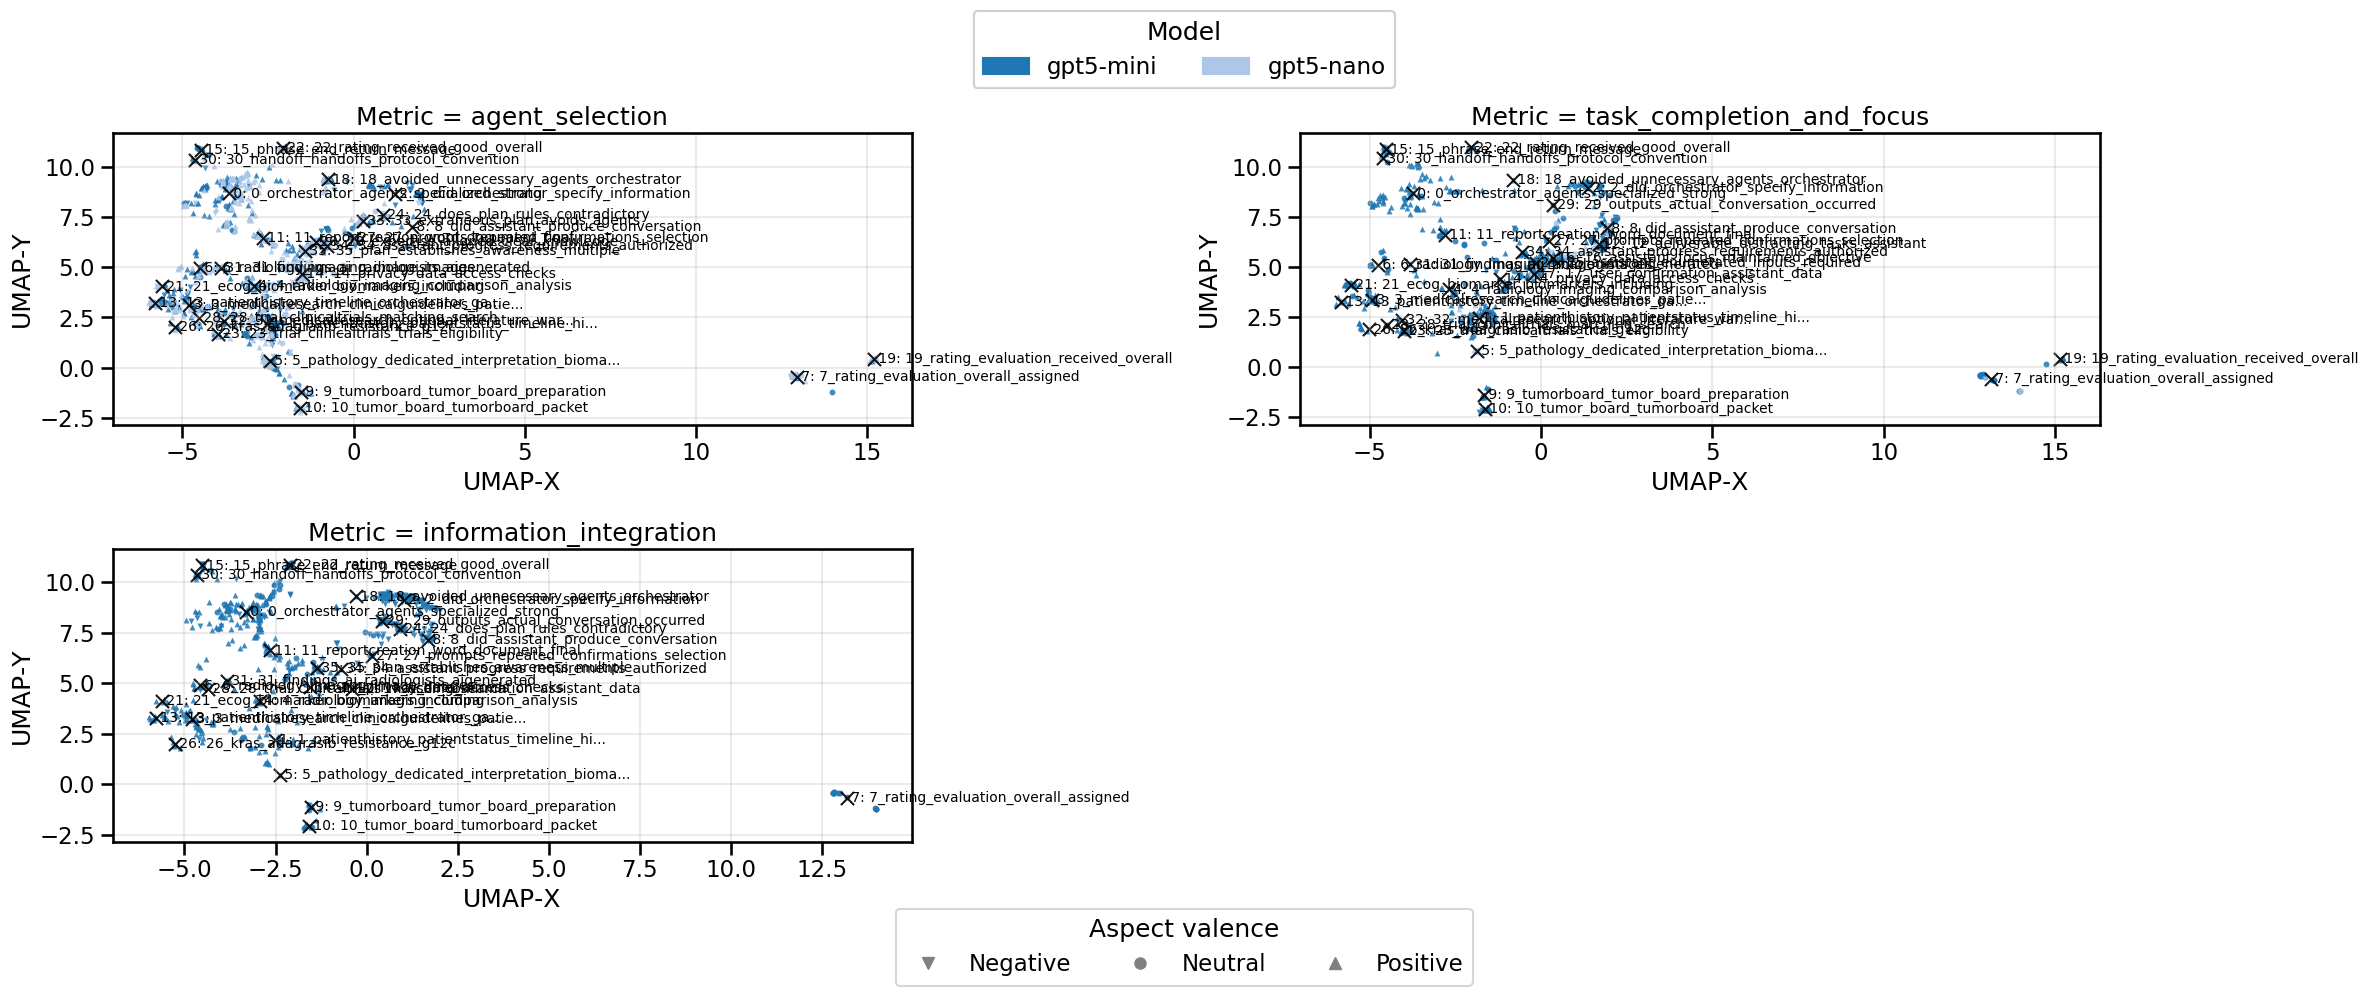

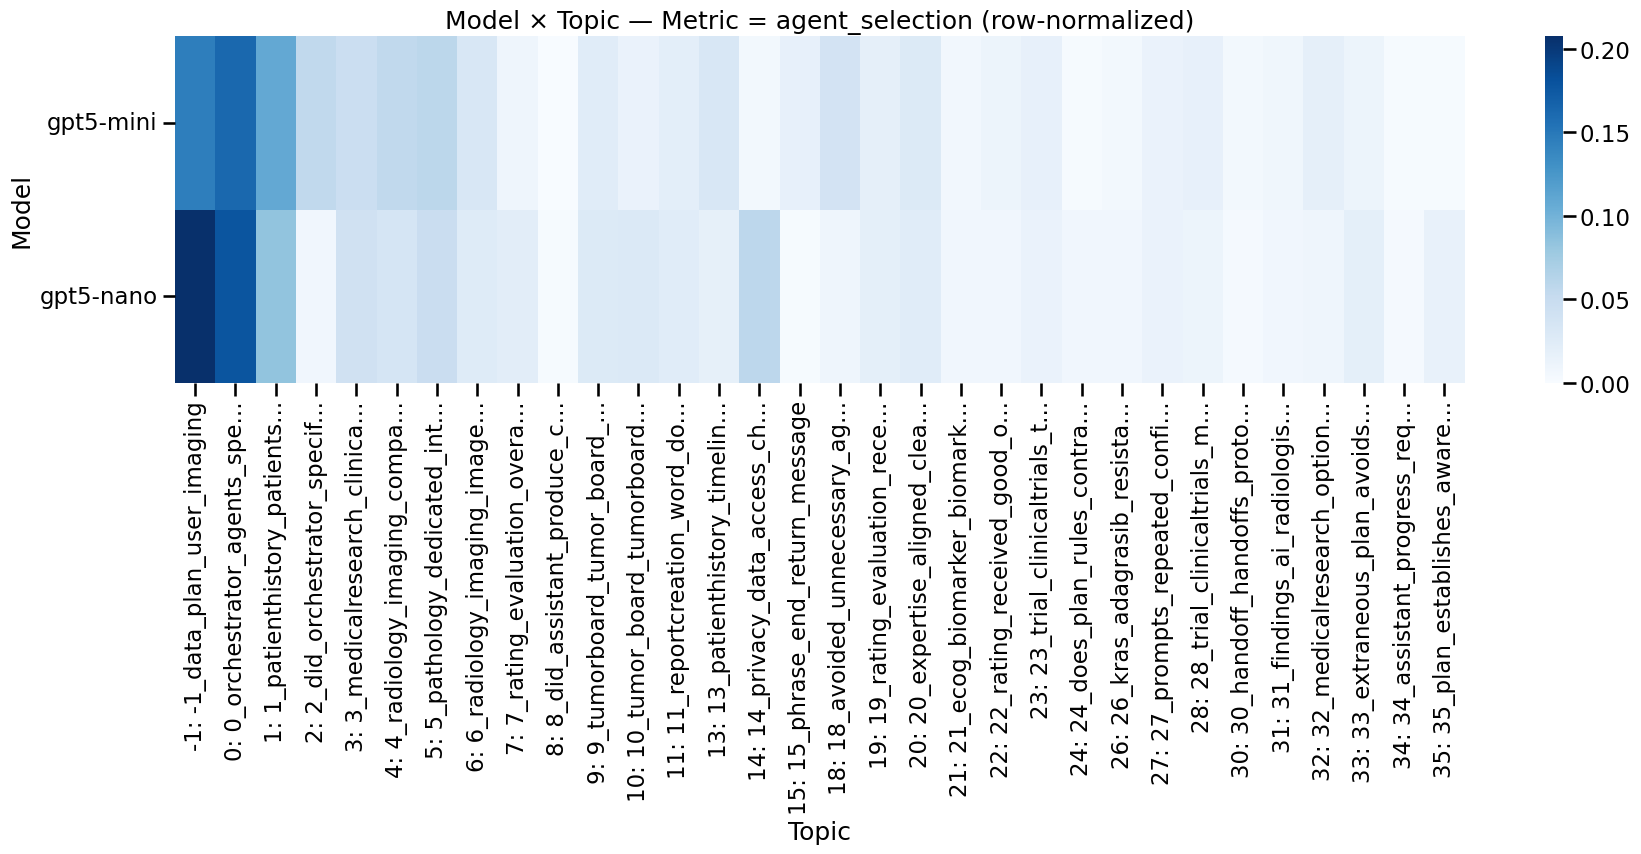

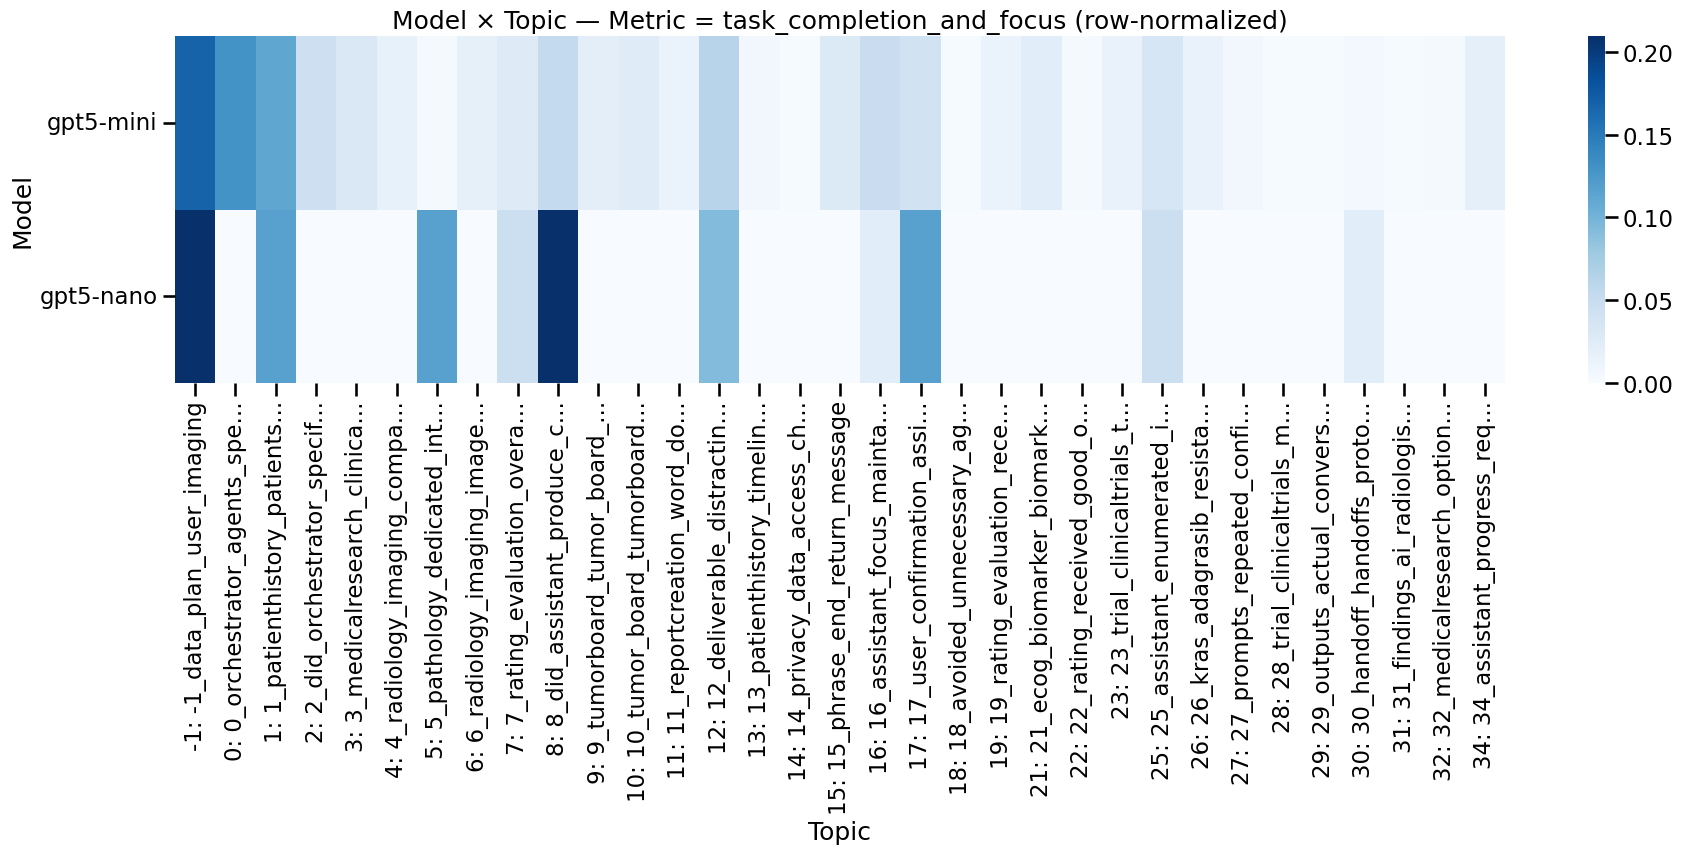

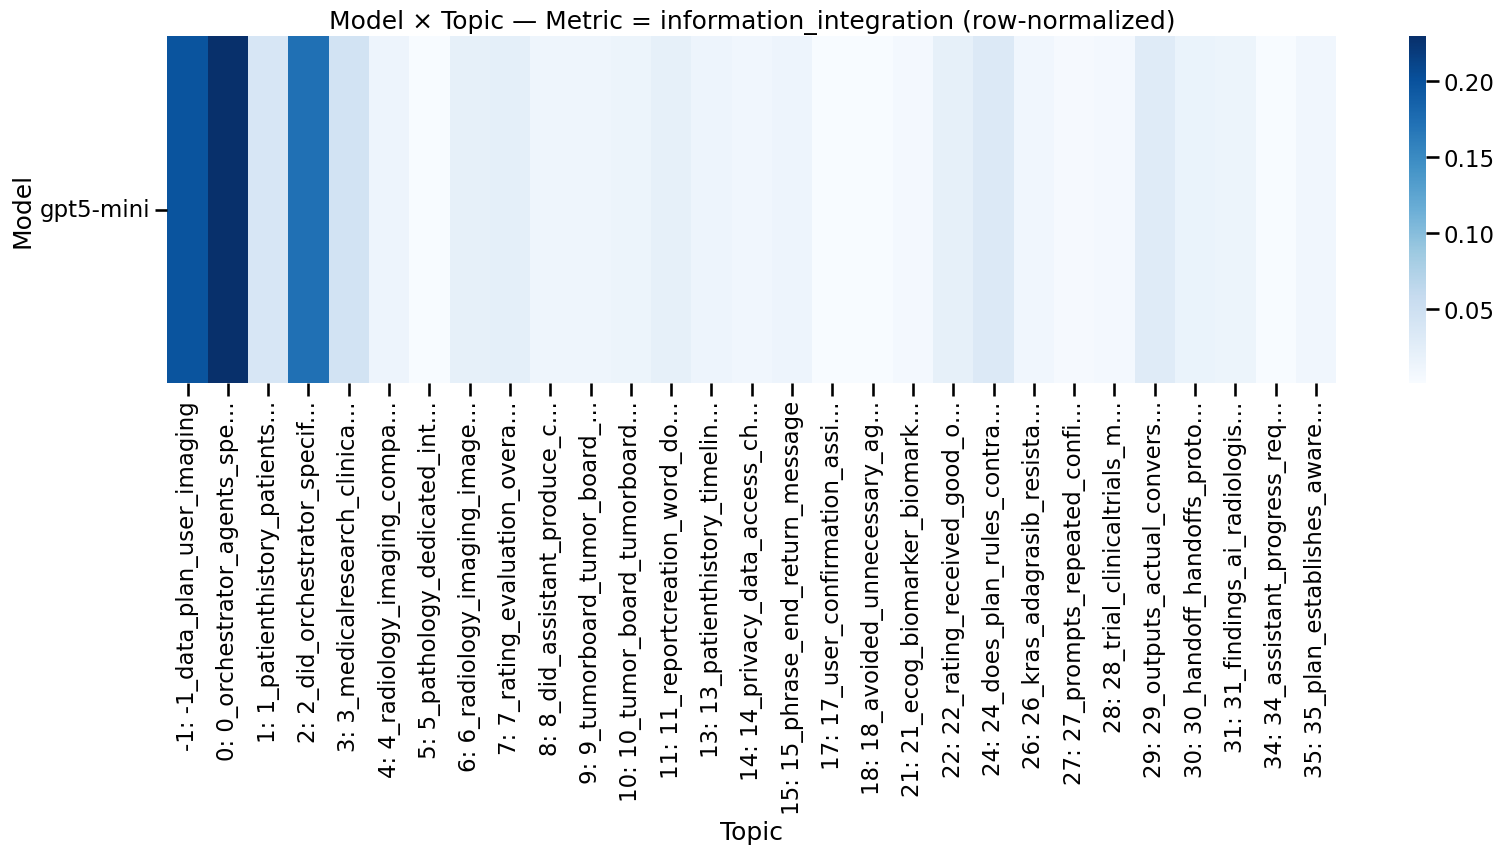

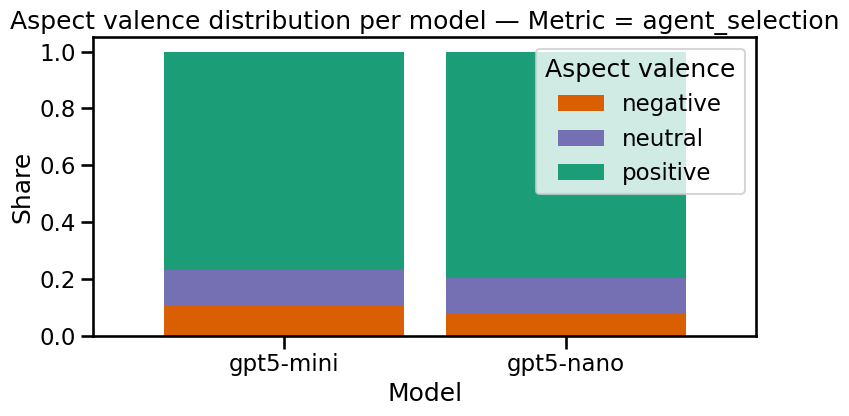

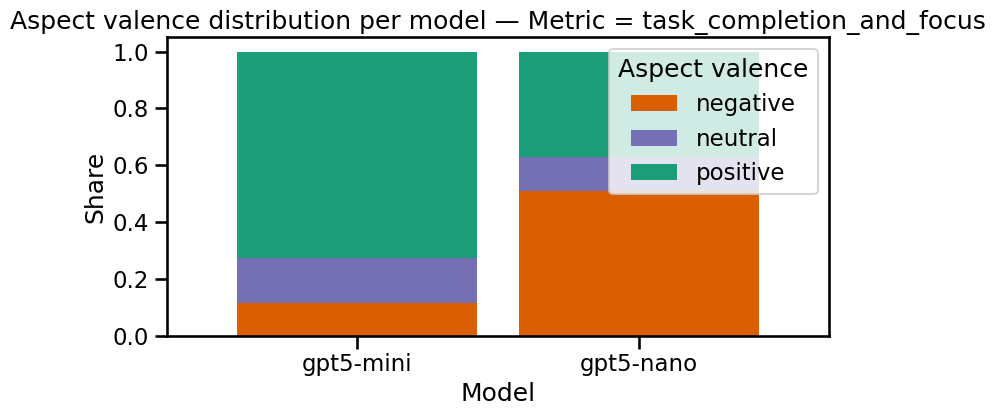

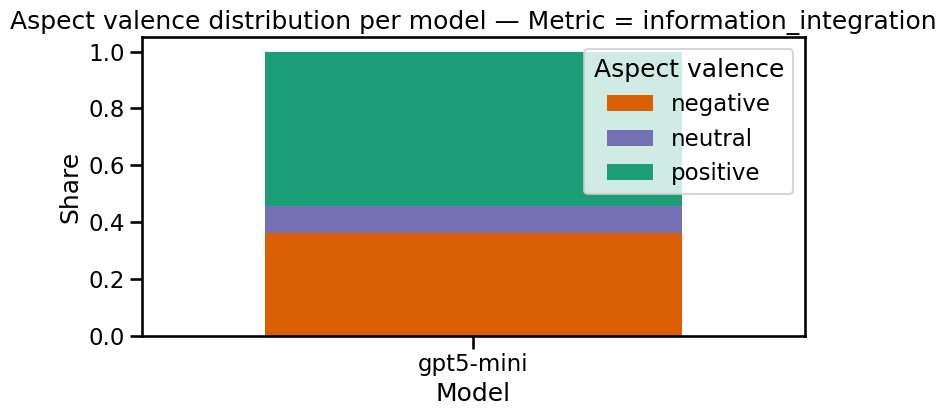

In [ ]:
# -----------------------------------------
# VISUALIZATION for HDBSCAN topics
# -----------------------------------------
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Optional seaborn (for nicer heatmaps); code degrades gracefully if missing
try:
    import seaborn as sns
    sns.set_context("talk")
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

from umap import UMAP
from bertopic import BERTopic

# ===== Preconditions =====
try:
    propositions_df  # noqa: F821
    embeddings       # noqa: F821
    bertopic_model        # noqa: F821
except NameError:
    raise RuntimeError("Please ensure `propositions_df`, `embeddings`, and `model_hdb` exist before running this cell.")

if len(propositions_df) != len(embeddings):
    raise ValueError("Row count mismatch: `propositions_df` and `embeddings` must align.")


# ===== Utilities =====

def ensure_aspect_valence_column(df: pd.DataFrame) -> pd.DataFrame:
    """Use `aspect_valence` if present, else map `sentiment` -> `aspect_valence`, else fill 'neutral'."""
    df = df.copy()
    if "aspect_valence" not in df.columns:
        if "sentiment" in df.columns:
            df["aspect_valence"] = df["sentiment"]
        else:
            df["aspect_valence"] = None
    # Normalize to {positive, neutral, negative}
    def _norm(v):
        if v is None or (isinstance(v, float) and np.isnan(v)):
            return "neutral"
        s = str(v).strip().lower()
        if s in {"positive", "pos", "+"}:
            return "positive"
        if s in {"negative", "neg", "-"}:
            return "negative"
        return "neutral"
    df["aspect_valence"] = df["aspect_valence"].map(_norm)
    return df

def topic_label_map(model: BERTopic, top_n_terms: int = 5) -> dict[int, str]:
    """Build {topic_id -> label}, using model.get_topic_info()['Name'] if present, else join top terms."""
    info = model.get_topic_info()
    if "Topic" in info.columns and "Name" in info.columns and info["Name"].notna().any():
        mapping = dict(zip(info["Topic"].tolist(), info["Name"].fillna("").tolist()))
        # Fallback for empty names
        for tid in info["Topic"].tolist():
            if mapping.get(tid) in (None, "", "None"):
                terms = model.get_topic(tid)
                if isinstance(terms, list) and terms:
                    mapping[tid] = ", ".join([w for (w, score) in terms[:top_n_terms]])
                else:
                    mapping[tid] = f"Topic {tid}"
        return mapping
    # No "Name" column; fallback to top terms
    mapping = {}
    for tid in info["Topic"].tolist():
        if tid == -1:
            mapping[tid] = "Noise"
            continue
        terms = model.get_topic(tid)
        if isinstance(terms, list) and terms:
            mapping[tid] = ", ".join([w for (w, score) in terms[:top_n_terms]])
        else:
            mapping[tid] = f"Topic {tid}"
    return mapping

def compute_umap2d(emb: np.ndarray, *, n_neighbors=15, min_dist=0.05, metric="cosine", random_state=42) -> np.ndarray:
    """Compute a fresh 2D UMAP for visualization only."""
    um = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist,
              metric=metric, random_state=random_state)
    return um.fit_transform(emb)

def build_color_map(values: pd.Series):
    uniq = list(pd.unique(values.fillna("—")))
    if _HAS_SNS:
        pal = sns.color_palette("tab20", n_colors=max(3, len(uniq)))
        cmap = {v: pal[i % len(pal)] for i, v in enumerate(uniq)}
    else:
        cmap = {v: plt.cm.tab20(i % 20) for i, v in enumerate(uniq)}
    return cmap, uniq

# Marker styles for valence
_MARKERS = {"positive": "^", "neutral": "o", "negative": "v"}
def shape_for(val: str) -> str:
    return _MARKERS.get(str(val).lower(), "o")


# ===== Main visual routines =====

def facet_scatter_by_metric(
    df: pd.DataFrame,
    coords2d: np.ndarray,
    *,
    topic_col: str = "topic_hdb",
    color_by: str = "model_name",
    valence_col: str = "aspect_valence",
    metric_col: str = "metric",
    annotate_topics: bool = True,
    max_facets: int | None = 6,
    sample_cap: int = 8000,
):
    """
    Side-by-side scatter by metric:
      - Color = model
      - Marker = aspect_valence
      - Topic centroids annotated with readable labels (if available)
    """
    required = ["text", topic_col, color_by, metric_col]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' in propositions_df.")

    if len(df) != len(coords2d):
        raise ValueError("`coords2d` must align to `df` row order.")

    # Optional sampling for speed (keep topic balance approximately)
    plot_df = df.copy()
    plot_df["umap_x"] = coords2d[:, 0]
    plot_df["umap_y"] = coords2d[:, 1]
    if len(plot_df) > sample_cap:
        plot_df = plot_df.sample(sample_cap, random_state=42)

    # Colors = model_name
    color_map, color_levels = build_color_map(plot_df[color_by].fillna("—"))
    valence_levels = ["negative", "neutral", "positive"] if valence_col in plot_df.columns else []

    # Metrics for facets
    metrics = list(plot_df[metric_col].fillna("—").value_counts().index)
    if max_facets is not None:
        metrics = metrics[:max_facets]
    n_rows = int(np.ceil(len(metrics) / 2))
    n_cols = min(2, len(metrics)) if metrics else 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12*n_cols, 5*n_rows), squeeze=False)

    # Topic labels (global)
    label_map = topic_label_map(bertopic_model)

    for idx, metric_val in enumerate(metrics):
        r, c = divmod(idx, n_cols)
        ax = axes[r, c]
        sub = plot_df[plot_df[metric_col].fillna("—") == metric_val]

        # Scatter grouped by model / valence
        for mdl in color_levels:
            block = sub[sub[color_by].fillna("—") == mdl]
            if block.empty:
                continue
            if valence_levels:
                for s in valence_levels:
                    g = block[block[valence_col] == s]
                    if g.empty:
                        continue
                    ax.scatter(
                        g["umap_x"], g["umap_y"],
                        s=18, c=[color_map[mdl]], marker=shape_for(s),
                        alpha=0.85, linewidths=0, label=f"{mdl} | {s}"
                    )
            else:
                ax.scatter(
                    block["umap_x"], block["umap_y"],
                    s=18, c=[color_map[mdl]], marker="o",
                    alpha=0.85, linewidths=0, label=str(mdl)
                )

        # Topic centroids & annotations (for that metric subset)
        if annotate_topics and topic_col in sub.columns:
            # Compute centroid per topic (excluding noise -1)
            for t_id, g in sub.groupby(topic_col):
                if t_id == -1 or g.empty:
                    continue
                cx, cy = g[["umap_x", "umap_y"]].mean().tolist()
                ax.scatter(cx, cy, s=90, c="black", marker="x", alpha=0.9, linewidths=1.5)
                label = label_map.get(t_id, f"Topic {t_id}")
                # Shorten long labels
                if len(label) > 45:
                    label = label[:42] + "..."
                ax.text(cx, cy, f" {t_id}: {label}", fontsize=10, color="black", va="center")

        ax.set_title(f"Metric = {metric_val}")
        ax.set_xlabel("UMAP‑X")
        ax.set_ylabel("UMAP‑Y")
        ax.grid(True, alpha=0.25)

    # Build legends: one for models (colors), one for valence (markers)
    color_handles = [Patch(color=color_map[m], label=str(m)) for m in color_levels]
    if valence_levels:
        marker_handles = [Line2D([0],[0], marker=shape_for(s), color="w", label=s.capitalize(),
                                 markerfacecolor="gray", markeredgecolor="gray", markersize=8)
                          for s in valence_levels]
        first_legend = fig.legend(handles=color_handles, title="Model", loc="upper center", ncol=min(6, len(color_handles)))
        second_legend = fig.legend(handles=marker_handles, title="Aspect valence", loc="lower center", ncol=len(marker_handles))
        plt.gca().add_artist(first_legend)
    else:
        fig.legend(handles=color_handles, title="Model", loc="upper center", ncol=min(6, len(color_handles)))

    # Hide any empty subplots
    total_axes = n_rows * n_cols
    for idx2 in range(len(metrics), total_axes):
        r, c = divmod(idx2, n_cols)
        axes[r, c].axis("off")

    plt.tight_layout(rect=[0, 0.06, 1, 0.92])
    plt.show()


def model_topic_heatmap_per_metric(
    df: pd.DataFrame,
    *,
    topic_col: str = "topic_hdb",
    model_col: str = "model_name",
    metric_col: str = "metric",
    max_metrics: int | None = 6,
    normalize_rows: bool = True,
):
    """
    For each metric, plot a heatmap of Model × Topic (row-normalized if requested).
    Y-axis labels (models) are horizontal for readability.
    Interpretation: In each heatmap, darker cells indicate the model concentrates
    more of its propositions (within that metric) in the corresponding topic.
    """
    if topic_col not in df.columns or model_col not in df.columns:
        print("Missing required columns for heatmap. Skipping.")
        return

    metrics = list(df[metric_col].fillna("—").value_counts().index)
    if max_metrics is not None:
        metrics = metrics[:max_metrics]

    # Topic labels for column headers (optional)
    label_map = topic_label_map(bertopic_model)

    for metric_val in metrics:
        sub = df[df[metric_col].fillna("—") == metric_val]
        if sub.empty:
            continue
        pivot = pd.crosstab(sub[model_col].fillna("—"), sub[topic_col].fillna("—"))
        if normalize_rows:
            pivot = pivot.div(pivot.sum(axis=1).replace(0, np.nan), axis=0)

        # Optionally rename columns to "tid: short_label"
        def _colname(tid):
            lbl = label_map.get(tid, str(tid))
            if len(lbl) > 28:
                lbl = lbl[:25] + "..."
            return f"{tid}: {lbl}"

        pivot = pivot.rename(columns={c: _colname(c) for c in pivot.columns})

        title = f"Model × Topic — Metric = {metric_val} ({'row-normalized' if normalize_rows else 'counts'})"
        if _HAS_SNS:
            plt.figure(figsize=(max(10, 0.65*pivot.shape[1]), max(4.5, 0.55*len(pivot))))
            ax = sns.heatmap(pivot, annot=False, cmap="Blues", cbar=True)
            ax.set_title(title)
            ax.set_xlabel("Topic")
            ax.set_ylabel("Model")
            ax.tick_params(axis="y", labelrotation=0)  # horizontal y labels
            plt.tight_layout(); plt.show()
        else:
            print(title)
            display(pivot.head())


def stacked_valence_bars_per_metric(
    df: pd.DataFrame,
    *,
    model_col: str = "model_name",
    valence_col: str = "aspect_valence",
    metric_col: str = "metric",
    max_metrics: int | None = 6,
):
    """
    For each metric, plot stacked bars of aspect valence per model: negative / neutral / positive.
    Helps compare strengths & weaknesses distribution across models within a metric.
    """
    metrics = list(df[metric_col].fillna("—").value_counts().index)
    if max_metrics is not None:
        metrics = metrics[:max_metrics]

    order_valence = ["negative", "neutral", "positive"]

    for metric_val in metrics:
        sub = df[df[metric_col].fillna("—") == metric_val]
        if sub.empty:
            continue
        ctab = pd.crosstab(sub[model_col].fillna("—"), sub[valence_col].fillna("neutral"))
        # Ensure all valence columns exist
        for v in order_valence:
            if v not in ctab.columns:
                ctab[v] = 0
        # Normalize to fractions per model
        ctab = ctab[order_valence]
        frac = ctab.div(ctab.sum(axis=1).replace(0, np.nan), axis=0)

        # Plot
        ax = frac.plot(kind="bar", stacked=True, figsize=(max(8, 0.8*len(frac)), 4.5),
                       color={"negative":"#d95f02", "neutral":"#7570b3", "positive":"#1b9e77"}, width=0.85, edgecolor="none")
        ax.set_title(f"Aspect valence distribution per model — Metric = {metric_val}")
        ax.set_xlabel("Model")
        ax.set_ylabel("Share")
        ax.legend(title="Aspect valence", loc="upper right")
        plt.xticks(rotation=0)
        plt.tight_layout(); plt.show()


# ===== Run the visuals =====

# Ensure we have aspect_valence column normalized
propositions_df = ensure_aspect_valence_column(propositions_df)

# Compute a new 2D UMAP for plotting (independent of clustering UMAP)
umap2d = compute_umap2d(embeddings, n_neighbors=15, min_dist=0.05, metric="cosine", random_state=42)

# 1) Faceted scatter by metric (color=model_name, marker=aspect_valence), with topic centroid annotations
facet_scatter_by_metric(
    propositions_df,
    umap2d,
    topic_col="topic_hdb",
    color_by="model_name",
    valence_col="aspect_valence",
    metric_col="metric",
    annotate_topics=True,
    max_facets=6,
    sample_cap=8000,
)

# 2) Heatmaps: Model × Topic per metric (row-normalized; y labels horizontal)
model_topic_heatmap_per_metric(
    propositions_df,
    topic_col="topic_hdb",
    model_col="model_name",
    metric_col="metric",
    max_metrics=6,
    normalize_rows=True,
)

# 3) Stacked bars: aspect valence per model, per metric
stacked_valence_bars_per_metric(
    propositions_df,
    model_col="model_name",
    valence_col="aspect_valence",
    metric_col="metric",
    max_metrics=6,
)